In [1]:
import pandas as pd 
import numpy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
def breast_cancer():
    data = pd.read_csv('breast-cancer.csv',header=0) 
    return data

In [3]:
def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)
    print("Training features"+str(X_train.shape))
    print("Training label"+ str(y_train.shape))
    print("Test features"+ str(X_test.shape))
    print("Test label"+ str(y_test.shape))
    return X_train, X_test, y_train, y_test

In [4]:
bc_data = breast_cancer()

In [5]:
encoder = LabelEncoder()
bc_data['diagnosis'] = encoder.fit_transform(bc_data['diagnosis'])


In [6]:
breast_cancer_X = bc_data.iloc[:,2:]
breast_cancer_y = bc_data.iloc[:,1]


In [7]:
x_train,x_test,ytrain,ytest = train_test(breast_cancer_X,breast_cancer_y)

Training features(455, 30)
Training label(455,)
Test features(114, 30)
Test label(114,)


In [8]:
scale = StandardScaler()
Xtrain = scale.fit_transform(x_train)
Xtest = scale.transform(x_test)

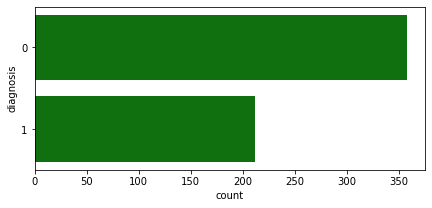

In [9]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="diagnosis", data=bc_data, color="g")
f.savefig("Figure1.png",pad_inches=0.1)

In [10]:
from sklearn.model_selection import StratifiedKFold,GridSearchCV,validation_curve,learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from sklearn import tree
import time
import numpy as np

 It took 0.011934757232666016 seconds 
0.9473684210526315


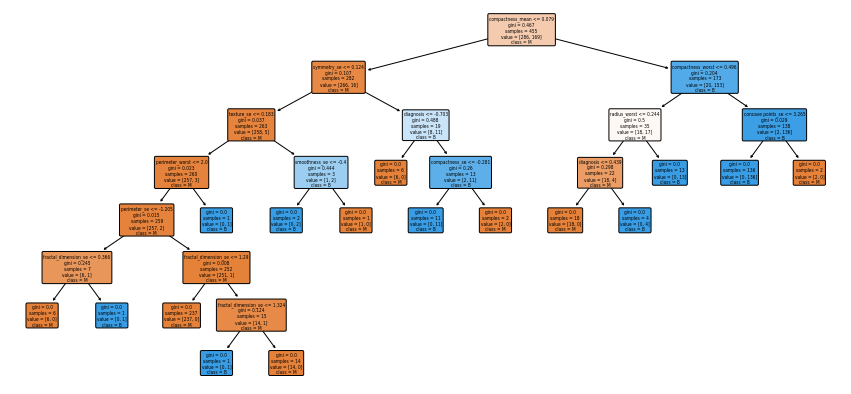

In [11]:
start_time = time.time()
decisionTree = DecisionTreeClassifier(random_state=42)

decisionTree.fit(Xtrain,ytrain)
BC_predSCore = decisionTree.predict(Xtest)
print(" It took %s seconds " % (time.time() - start_time))
print(accuracy_score(ytest,BC_predSCore))
plt.figure(figsize=(15,7))
tree.plot_tree(decisionTree, filled=True, rounded=True,class_names=["M","B"], feature_names = bc_data.columns);
plt.savefig('defaultTree.png',format='png',bbox_inches = "tight")



### Pruning

In [12]:
pruning_decisionTree = DecisionTreeClassifier(criterion="gini", splitter='random',
                                              max_leaf_nodes=10,
                                              min_samples_leaf = 3,
                                              max_depth = 4,
                                              random_state=42)
pruning_decisionTree.fit(Xtrain,ytrain)
bc_pruning_predict = pruning_decisionTree.predict(Xtest)
accuracy_score(ytest,bc_pruning_predict)

0.9385964912280702

In [13]:
def pruning_clf():
    clfs = DecisionTreeClassifier(criterion="gini", splitter='random',
                                              max_leaf_nodes=10,
                                              min_samples_leaf = 3,
                                              max_depth = 4,
                                              random_state=42)
    path = clfs.cost_complexity_pruning_path(Xtrain,ytrain)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(criterion="gini", splitter='random',
                                              max_leaf_nodes=10,
                                              min_samples_leaf = 3,
                                              max_depth = 4,
                                              random_state=42,ccp_alpha=ccp_alpha)
        clf.fit(Xtrain, ytrain)
        clfs.append(clf)
    train_scores = [clf.score(Xtrain,ytrain) for clf in clfs]
    test_scores = [clf.score(Xtest, ytest) for clf in clfs]

    print(ccp_alphas.mean())
    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
    plt.grid()
    
    ax.legend(loc='best')
    plt.savefig('postPruning.png',format='png',bbox_inches = "tight")
    plt.show()



0.04419593076419981


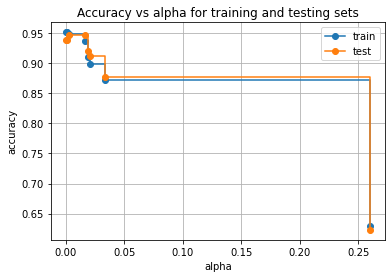

In [14]:
pruning_clf()

### Hyperparameter Tuning

In [15]:
def gridSearch(X,y):
    start_time = time.time()
    param_dict = {
    "criterion": ['gini', 'entropy'],
    "max_depth" : np.arange(1,20,1),
    "splitter": ['best', 'random'],
    "min_samples_split":range(2,10,2),
    "min_samples_leaf":range(1,10,2),
    }
    model = DecisionTreeClassifier(random_state=42)
    gv = GridSearchCV(model,param_grid=param_dict,cv=10,n_jobs=-1)
    gv.fit(X,y)
    print(" It took %s seconds " % (time.time() - start_time))
    return gv.best_score_,gv.best_params_
    

In [16]:
gridSearch(Xtrain,ytrain)

 It took 7.219311237335205 seconds 


(0.9582125603864734,
 {'criterion': 'gini',
  'max_depth': 4,
  'min_samples_leaf': 1,
  'min_samples_split': 8,
  'splitter': 'random'})

In [48]:
def classificationreport():
    model = DecisionTreeClassifier(criterion= 'gini',
      max_depth= 4,
      min_samples_leaf= 1,
      min_samples_split= 8,
      splitter= 'random',
        random_state=42,ccp_alpha=0.04)
    model.fit(Xtrain,ytrain)
    hyperTuningPredict = model.predict(Xtest)
    accuracy_score(ytest,hyperTuningPredict)*100
    
    print(confusion_matrix(ytest, hyperTuningPredict))
      
    print ("Accuracy : ",
        accuracy_score(ytest,hyperTuningPredict)*100)

    print(
        classification_report(ytest, hyperTuningPredict))

In [49]:

classificationreport()

[[69  2]
 [ 9 34]]
Accuracy :  90.35087719298247
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        71
           1       0.94      0.79      0.86        43

    accuracy                           0.90       114
   macro avg       0.91      0.88      0.89       114
weighted avg       0.91      0.90      0.90       114



In [19]:
def plot_learning_curve(x,y):
    dt = DecisionTreeClassifier(criterion= 'gini',
                                   max_depth= 4,
                                   min_samples_leaf= 1,
                                   min_samples_split= 8,
                                   splitter= 'random',
                                   random_state=42,ccp_alpha=0.04)
    
    
    train_sizes, train_scores, test_scores = learning_curve(dt,x,y, n_jobs=-1, cv=10, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
    
    dt.fit(x,y)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("Learning Curve - Breast Cancer")
    plt.legend("best")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Scoare")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.ylim(-.1,1.1)
    plt.savefig('DTLearningCurve.png',format='png',bbox_inches = "tight")
    plt.show()
    
    


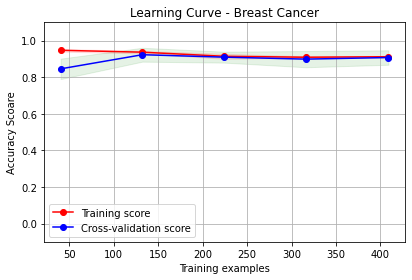

In [20]:
plot_learning_curve(Xtrain,ytrain)

In [21]:
def plot_validation_curve(x,y):
    dt = DecisionTreeClassifier(criterion= 'gini',
                                   min_samples_leaf= 1,
                                   min_samples_split= 8,
                                   splitter= 'random',
                                   random_state=42,ccp_alpha=0.04)
    

    
    train_score, test_score= validation_curve(dt,x,y,param_name="max_depth",param_range=np.arange(1,20),
                                        cv=10, scoring="accuracy")
    dt.fit(x,y)
    # Calculating mean and standard deviation of training score
    mean_train_score = np.mean(train_score, axis = 1)
    std_train_score = np.std(train_score, axis = 1)

    # Calculating mean and standard deviation of testing score
    mean_test_score = np.mean(test_score, axis = 1)
    std_test_score = np.std(test_score, axis = 1)
    
    plt.grid()

    # Plot mean accuracy scores for training and testing scores
    plt.plot(np.arange(1,20), mean_train_score,
         label = "Training Score",color = 'r')
    plt.plot(np.arange(1,20), mean_test_score,
       label = "Cross Validation Score", color = 'b')

    # Creating the plot
    plt.title(" DT - Validation Curve Breast Cancer")
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.savefig('DT-ValidationCurve.png',format='png',bbox_inches = "tight")
    plt.show()

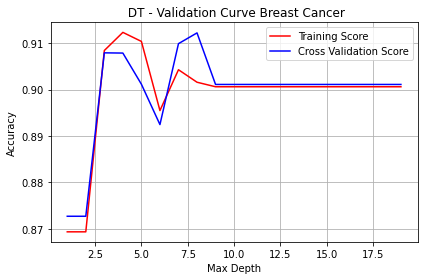

In [22]:
plot_validation_curve(Xtrain,ytrain)

In [23]:
def createTree():    
    dt = DecisionTreeClassifier(criterion= 'gini',
                                   min_samples_leaf= 1,
                                   min_samples_split= 8,
                                   splitter= 'random',
                                   random_state=42,ccp_alpha=0.04)

    dt.fit(Xtrain,ytrain)
    BC_predSCore = dt.predict(Xtest)
    accuracy_score(ytest,BC_predSCore)
    print(" It took %s seconds " % (time.time() - start_time))

    plt.figure(figsize=(15,7))
    tree.plot_tree(dt, filled=True, rounded=True,class_names=["Malignant","Benign"], feature_names = bc_data.columns);
    plt.savefig('DTtree.png',format='png',bbox_inches = "tight")

 It took 10.368851900100708 seconds 


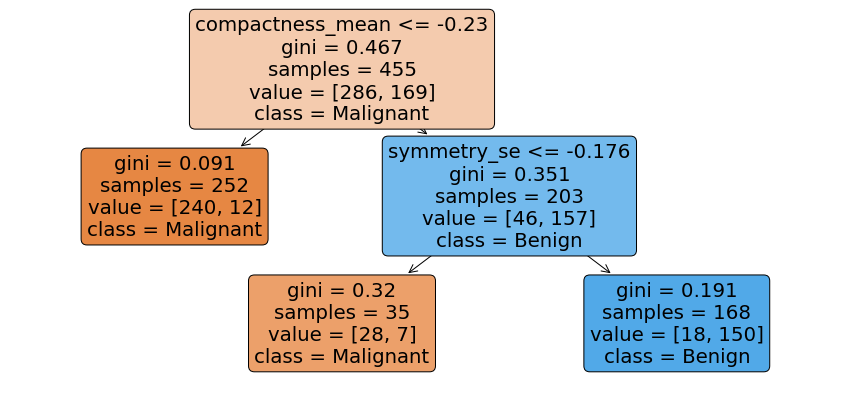

In [24]:
createTree()

# KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
start_time = time.time()
knn = KNeighborsClassifier()
knn.fit(Xtrain,ytrain)
knn_pred = knn.predict(Xtest)
print(" It took %s seconds " % (time.time() - start_time)) 
accuracy_score(ytest,knn_pred)


 It took 0.006526947021484375 seconds 


0.9473684210526315

In [27]:
knn_pruning = KNeighborsClassifier(n_neighbors=10)
knn_pruning.fit(Xtrain,ytrain)
knn_pred = knn_pruning.predict(Xtest)
accuracy_score(ytest,knn_pred)

0.956140350877193

In [28]:
def plot_knn_learning_curve(x,y):
    knnModel = KNeighborsClassifier(n_neighbors=20)
    
    train_sizes, train_scores, test_scores = learning_curve(knnModel, x,y, n_jobs=-1, cv=10, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
    
    knnModel.fit(x,y)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("KNN Learning Curve - Breast Cancer")
    plt.legend("best")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Scoare")
    #plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")
    #plt.tight_layout()
    plt.legend(loc = 'best')
    plt.savefig('KNNLearningcurveBreastCancer.png',format='png',bbox_inches = "tight")
  
    plt.ylim(-.1,1,.10)
    plt.show()
    

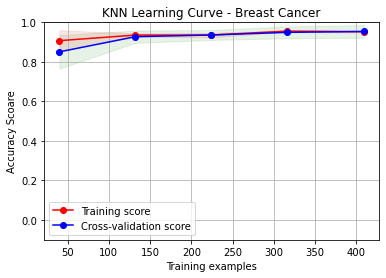

In [29]:
plot_knn_learning_curve(Xtrain,ytrain)

In [30]:
def knn_validationCurve(x,y):
    parameter_range = np.arange(1, 20, 1)
    train_score, test_score = validation_curve(KNeighborsClassifier(),x,y,
                                           param_name = "n_neighbors",
                                           param_range = parameter_range,
                                            cv = 5, scoring = "accuracy")
    mean_train_score = np.mean(train_score, axis = 1)
    std_train_score = np.std(train_score, axis = 1)

    # Calculating mean and standard deviation of testing score
    mean_test_score = np.mean(test_score, axis = 1)
    std_test_score = np.std(test_score, axis = 1)

    # Plot mean accuracy scores for training and testing scores
    plt.plot(parameter_range, mean_train_score,
         label = "Training Score", color = 'b')
    plt.plot(parameter_range, mean_test_score,
       label = "Cross Validation Score", color = 'g')

    # Creating the plot
    plt.title("Validation Curve with KNN Classifier")
    plt.xlabel("Number of Neighbours")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.savefig('KNNValidationCurveBC.png',format='png',bbox_inches = "tight")
    plt.show()

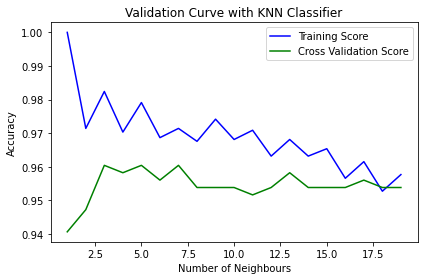

In [31]:
knn_validationCurve(Xtrain,ytrain)

In [32]:
def knnGridSearch(X,y):
    start_time = time.time()
    param_dict = {
    "weights": ['uniform', 'distance'],
    "n_neighbors" : np.arange(1,30,1),
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "leaf_size":range(2,30,2)
    }
    knnModel = KNeighborsClassifier()
    gv = GridSearchCV(knnModel,param_grid=param_dict,cv=10,n_jobs=-1)
    gv.fit(X,y)
    print(" It took %s seconds " % (time.time() - start_time))
    return gv.best_score_,gv.best_params_

In [33]:
knnGridSearch(Xtrain,ytrain)

 It took 10.253300189971924 seconds 


(0.971304347826087,
 {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 7, 'weights': 'uniform'})

In [33]:
def KNNAfterNuning():
    knnModel = KNeighborsClassifier(algorithm = 'auto',
                                    leaf_size = 2,
                                    n_neighbors= 7,
                                    weights = 'uniform')
    knnModel.fit(Xtrain,ytrain)
    knnPredict = knnModel.predict(Xtest)
    accuracy_score(ytest,knnPredict)
    
    print(confusion_matrix(ytest, knnPredict))
      
    print ("Accuracy : ",accuracy_score(ytest, knnPredict)*100)
      
    print(classification_report(ytest, knnPredict))

    



In [34]:
KNNAfterNuning()

[[68  3]
 [ 3 40]]
Accuracy :  94.73684210526315
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



# Support Vector Machine

In [68]:
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit

In [69]:
svmModel = SVC(random_state=42)
start_time = time.time()
svmModel.fit(Xtrain,ytrain)
y_pred_svm = svmModel.predict(Xtest)
print("Accuracy:",accuracy_score(ytest, y_pred_svm))
print(" It took %s seconds " % (time.time() - start_time)) 

Accuracy: 0.9824561403508771
 It took 0.0162050724029541 seconds 


In [140]:
def plot_SVM_learning_curve(X,y):
    #cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    svmModel = SVC()
    
    train_sizes, train_scores, test_scores = learning_curve(svmModel,X,y,
                                                            n_jobs=-1, cv=10, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
    
    svmModel.fit(X,y)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("SVM Learning Curve - Breast Cancer")
    plt.legend("best")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Scoare")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.ylim(-.1,1.10,.10)
    plt.savefig('svm_learningCurveBC.png',format='png',bbox_inches = "tight")
   
  
    plt.show()

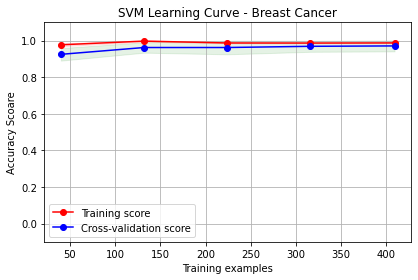

In [141]:
plot_SVM_learning_curve(Xtrain,ytrain)

In [142]:
def SVM_validationCurve(X,y):
    parameter_range = np.arange(1, 11, 1)
    
    train_score, test_score = validation_curve(SVC(C = 10),X,y,
                                           param_name = "C",
                                           param_range = parameter_range,
                                            cv = 10, scoring = "accuracy")
    mean_train_score = np.mean(train_score, axis = 1)
    std_train_score = np.std(train_score, axis = 1)

    # Calculating mean and standard deviation of testing score
    mean_test_score = np.mean(test_score, axis = 1)
    std_test_score = np.std(test_score, axis = 1)

    # Plot mean accuracy scores for training and testing scores
    plt.plot(parameter_range, mean_train_score,
         label = "Training Score", color = 'b')
    plt.plot(parameter_range, mean_test_score,
       label = "Cross Validation Score", color = 'g')

    # Creating the plot
    plt.title("Validation Curve with SVM Classifier")
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.savefig('SVM_validation_BC.png',format='png',bbox_inches = "tight")
    plt.show()

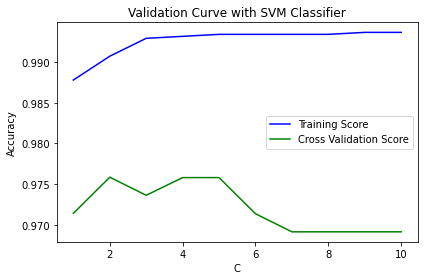

In [143]:
SVM_validationCurve(Xtrain,ytrain)

In [39]:
def svm(X,y):
    start_time = time.time()
    model = SVC(random_state=42)
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
                  'gamma' : [0.001, 0.01, 0.1, 1],
                 'kernel': ['linear','rbf']}

    
    gv = GridSearchCV(model, param_grid, cv=10)
    gv.fit(X,y)
    print(" It took %s seconds " % (time.time() - start_time))
    return gv.best_score_,gv.best_params_

In [40]:
svm(Xtrain,ytrain)

 It took 2.578500270843506 seconds 


(0.9780676328502415, {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'})

In [70]:
def SVMAfterTuning(x,y,xtext,Ytest):
    SVM_model = SVC(C = 0.1, gamma = 0.001, kernel = 'linear')
    SVM_model.fit(x,y)
    SVM_Predict = SVM_model.predict(xtext)
    accuracy_score(Ytest,SVM_Predict)
    
    print(confusion_matrix(Ytest, SVM_Predict))
      
    print ("Accuracy : ",accuracy_score(ytest, SVM_Predict)*100)
      
    print(classification_report(Ytest, SVM_Predict))
 

    


    

In [71]:
SVMAfterTuning(Xtrain,ytrain,Xtest,ytest)

[[71  0]
 [ 2 41]]
Accuracy :  98.24561403508771
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



# Ada Boosting


In [54]:
from sklearn.ensemble import AdaBoostClassifier

In [55]:
start_time = time.time()
adaboostModel = AdaBoostClassifier(DecisionTreeClassifier(
    max_depth=4,splitter = 'random',criterion='gini',min_samples_leaf=1,min_samples_split=8), n_estimators=1)
adaboostModel.fit(Xtrain,ytrain)
adaboostModelPred = adaboostModel.predict(Xtest)
print(" It took %s seconds " % (time.time() - start_time))
print("Accuracy:",accuracy_score(ytest, adaboostModelPred))

 It took 0.011080026626586914 seconds 
Accuracy: 0.956140350877193


In [56]:
def plot_ADA_learning_curve(X,y):
    #cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    adaboostModel_learningCurve = AdaBoostClassifier(DecisionTreeClassifier(
    max_depth=4,splitter = 'random',criterion='gini',min_samples_leaf=1,min_samples_split=8,random_state=42), n_estimators=1)
    
    train_sizes, train_scores, test_scores = learning_curve(adaboostModel_learningCurve,X,y,
                                                            n_jobs=-1, cv=10, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
    
    adaboostModel_learningCurve.fit(X,y)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("ADA Learning Curve - Breast Cancer")
    plt.legend("best")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Scoare")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.ylim(-.1,1.10,.10)
    plt.savefig('adalearningcurve.png',format='png',bbox_inches = "tight")
  
    plt.show()

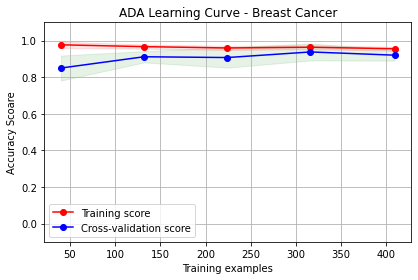

In [57]:
plot_ADA_learning_curve(Xtrain,ytrain)

In [58]:
def ada_validationCurve(X,y):
    parameter_range = np.arange(1, 11, 1)
    
    train_score, test_score = validation_curve(AdaBoostClassifier(DecisionTreeClassifier(
    max_depth=4,splitter = 'random',criterion='gini',min_samples_leaf=1,min_samples_split=8, random_state=42)),X,y,
                                           param_name = "n_estimators",
                                           param_range = parameter_range,
                                            cv = 10, scoring = "accuracy")
    mean_train_score = np.mean(train_score, axis = 1)
    std_train_score = np.std(train_score, axis = 1)

    # Calculating mean and standard deviation of testing score
    mean_test_score = np.mean(test_score, axis = 1)
    std_test_score = np.std(test_score, axis = 1)

    # Plot mean accuracy scores for training and testing scores
    plt.plot(parameter_range, mean_train_score,
         label = "Training Score", color = 'b')
    plt.plot(parameter_range, mean_test_score,
       label = "Cross Validation Score", color = 'r')

    # Creating the plot
    plt.title("Validation Curve with ADA boost")
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.savefig('adavalidationcurve.png',format='png',bbox_inches = "tight")
    plt.show()

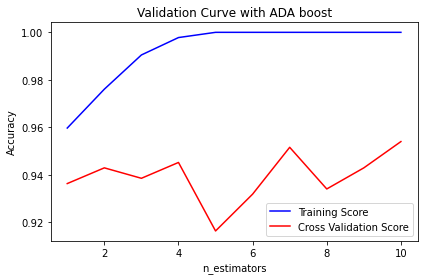

In [59]:
ada_validationCurve(Xtrain,ytrain)

In [60]:
def adaGV(X,y):
    start_time = time.time()
    
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,splitter = 'random',criterion='gini',min_samples_leaf=1,min_samples_split=8, random_state=42))
    param_grid = {'n_estimators': np.arange(1, 100, 10),
                  'learning_rate' : np.arange(0.1, 1, .1),
                  'algorithm': ['SAMME', 'SAMME.R']}

    
    gv = GridSearchCV(model, param_grid, cv=10)
    gv.fit(X,y)
    print(" It took %s seconds " % (time.time() - start_time))
    return gv.best_score_,gv.best_params_

In [61]:
adaGV(Xtrain,ytrain)

 It took 71.41087579727173 seconds 


(0.9824154589371981,
 {'algorithm': 'SAMME', 'learning_rate': 0.9, 'n_estimators': 91})

In [64]:
def adaAfterTuning(x,y,xtext,Ytest):
    adaModel = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,
                                                         splitter = 'random',
                                                         criterion='gini',
                                                         min_samples_leaf=1,
                                                         min_samples_split=8, 
                                                         random_state=42),
                                  algorithm='SAMME',
                                  learning_rate=0.7000000000000001,
                                  n_estimators = 71
                                 )
    
    
    
    adaModel.fit(x,y)
    Ada_Predict = adaModel.predict(xtext)
    accuracy_score(Ytest,Ada_Predict)
    
    print(confusion_matrix(Ytest, Ada_Predict))
      
    print ("Accuracy : ",accuracy_score(ytest, Ada_Predict)*100)
      
    print(classification_report(Ytest, Ada_Predict))


In [65]:
adaAfterTuning(Xtrain,ytrain,Xtest,ytest)

[[70  1]
 [ 2 41]]
Accuracy :  97.36842105263158
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



# Neural Netwrok

In [36]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [37]:
start_time = time.time()
NNModel = MLPClassifier(random_state=40)
NNModel.fit(Xtrain,ytrain)
nnmodelPrect = NNModel.predict(Xtest)
print(" It took %s seconds " % (time.time() - start_time)) 
print("Accuracy:",accuracy_score(ytest, nnmodelPrect))

 It took 0.5252161026000977 seconds 
Accuracy: 0.9736842105263158


In [38]:
def plot_NN_learning_curve(X,y):
   
    NN_learningCurve = MLPClassifier(random_state=40)
    train_sizes, train_scores, test_scores = learning_curve(NN_learningCurve,X,y,
                                                            n_jobs=-1, cv=10, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
  
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("NN Learning Curve - Breast Cancer")
    plt.legend("best")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Scoare")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.ylim(-.1,1.10,.10)
    plt.savefig('NNBreastCancer.png',format='png',bbox_inches = "tight")
   
  
    plt.show()

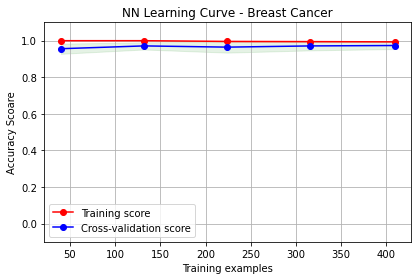

In [39]:
plot_NN_learning_curve(Xtrain,ytrain)

In [40]:
def NN_Before_Tuning(x,y,xtext,Ytest):
    NN_learning_Curve = MLPClassifier(random_state=40)
    
    
    
    NN_learning_Curve.fit(x,y)
    Ada_Predict = NN_learning_Curve.predict(xtext)
    accuracy_score(Ytest,Ada_Predict)
    
    print(confusion_matrix(Ytest, Ada_Predict))
      
    print ("Accuracy : ",accuracy_score(ytest, Ada_Predict)*100)
      
    print(classification_report(Ytest, Ada_Predict))


In [41]:
NN_Before_Tuning(Xtrain,ytrain,Xtest,ytest)

[[70  1]
 [ 2 41]]
Accuracy :  97.36842105263158
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [89]:
def NN_GV(X,y):
    start_time = time.time()
    
    model = MLPClassifier(max_iter=100,random_state=40)
    
    
    param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                  'activation' :['identity','logistic', 'tanh', 'relu'],
                  'alpha': [0.0001, 0.05],
                 'max_iter': np.arange(200, 600, 100)}

    
    gv = GridSearchCV(model, param_grid, cv=10)
    gv.fit(X,y)
    print(" It took %s seconds " % (time.time() - start_time))
    return gv.best_score_,gv.best_params_

In [90]:
NN_GV(Xtrain,ytrain)

/Users/rachanapandey/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rachanapandey/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rachanapandey/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rachanapandey/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

 It took 867.4975497722626 seconds 


(0.9824154589371981,
 {'activation': 'relu',
  'alpha': 0.0001,
  'hidden_layer_sizes': (50, 100, 50),
  'max_iter': 200})

In [46]:
def nn_validationCurve(X,y):
    
    
    train_score, test_score = validation_curve(MLPClassifier(random_state=42,
                                                             activation='relu',
                                                             alpha=0.0001,
                                                             hidden_layer_sizes= (50, 100, 50),
                                                             
                                                            solver='adam'),X,y,param_name = 'max_iter',param_range=  np.arange(200, 600, 100))
    
    
    mean_train_score = np.mean(train_score, axis = 1)
    std_train_score = np.std(train_score, axis = 1)

    # Calculating mean and standard deviation of testing score
    mean_test_score = np.mean(test_score, axis = 1)
    std_test_score = np.std(test_score, axis = 1)

    # Plot mean accuracy scores for training and testing scores
    plt.plot(np.arange(200, 600, 100), mean_train_score,
         label = "Training Score", color = 'b')
    plt.plot(np.arange(200, 600, 100), mean_test_score,
       label = "Cross Validation Score", color = 'g')

    # Creating the plot
    plt.title("Validation Curve with NN")
    plt.xlabel("max_iter")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.savefig('NNBreastCancerValidationCurve.png',format='png',bbox_inches = "tight")
    plt.show()
    

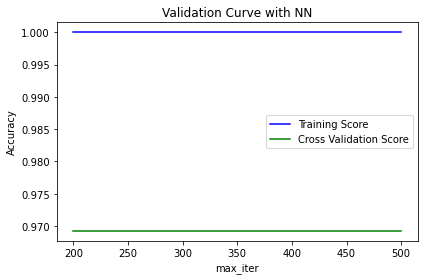

In [47]:
nn_validationCurve(Xtrain,ytrain)

In [44]:
def NN_Tuning(x,y,xtext,Ytest):
    NN_learning_Curve = MLPClassifier(random_state=42,activation='relu',alpha=0.0001,hidden_layer_sizes= (50, 100, 50),
                                                            max_iter=200,
                                                            solver='adam')
    
    
    
    NN_learning_Curve.fit(x,y)
    Ada_Predict = NN_learning_Curve.predict(xtext)
    accuracy_score(Ytest,Ada_Predict)
    
    print(confusion_matrix(Ytest, Ada_Predict))
      
    print ("Accuracy : ",accuracy_score(ytest, Ada_Predict)*100)
      
    print( classification_report(Ytest, Ada_Predict))
    
    
    plt.plot(NN_learning_Curve.loss_curve_)
    plt.title("Loss Curve", fontsize=14)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()


[[70  1]
 [ 1 42]]
Accuracy :  98.24561403508771
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



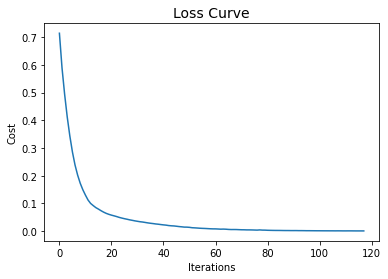

In [45]:
NN_Tuning(Xtrain,ytrain,Xtest,ytest)